# Monte Carlo Simulations in Finance Part2


## References
- Options, futures, and other derivatives. Chapter22 Chapter19 Chapter13
- Derivatives Analytics with Python: Data Analysis, Models, Simulation, Calibration and Hedging. Chapter7 Chapter10.4
- Valuing American Options by Simulation:
A Simple Least-Squares Approach.https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf
- Master Polynomial Regression With Easy-to-Follow Tutorials.https://www.analyticsvidhya.com/blog/2021/07/all-you-need-to-know-about-polynomial-regression/
- Official QuantLib Documentation. https://www.quantlib.org/docs.shtml  https://quantlib-python-docs.readthedocs.io/en/latest/
- QuantLib天数计算规则详解.https://www.cnblogs.com/xuruilong100/p/8995217.html#actualactual-icma
- FpML to QuantLib 外滙美式選擇權估值 https://blog.csdn.net/alvincho/article/details/89929334
- Pricing Options on Robinhood using Robinstocks and QuantLib https://medium.datadriveninvestor.com/pricing-options-on-robinhood-using-robinstocks-and-quantlib-7bc765088ced
- QuantLib 金融计算——原理之 Quote、Handle 与观察者模式.https://www.cnblogs.com/xuruilong100/p/14375297.html
- Vanilla Option: Definition, Types of Option, Features and Example. https://www.investopedia.com/terms/v/vanillaoption.asp
- Simulate Multi-Asset Baskets With Correlated Price Paths Using Python.https://medium.com/codex/simulate-multi-asset-baskets-with-correlated-price-paths-using-python-472cbec4e379
- Cholesky decomposition.https://en.wikipedia.org/wiki/Cholesky_decomposition#Monte_Carlo_simulation
- Kolmogorov backward/forward equations (diffusion).https://en.wikipedia.org/wiki/Kolmogorov_backward_equations_(diffusion)


## Pricing American Options with Least Squares Monte Carlo(LSMC)
- For any time step $t$, the early exercise is performed if payoff from immediate exercise > continuation value
  - $V_t(s)=max(h_t(s),C_t(s))$
    - $h_t(s)$: option's payoff, inner value
    - $C_t(s)$: continuation value
      - $C_t(s)=E^Q_t[e^{-rdt}V_{t+dt}S_{t_dt}|S_t=s]$
        - $r$: risk free rate
        - $E^Q[...|S_t=s]$: conditional <u>risk neutral expectation</u> with given underlying price
        - $e^{-rdt}V_{t+dt,i}$: MC simulated continuation value for each time step and sample path
- Calculation Methods:
  - use `OLS regression` to estimated the expected continuation value, discounted to the present value with **X-degree polynomial regression** to identify the *curvilinear* relationship.
    - Polynomial regression: find the proper degree to gain accuracy and avoid overfitting
      - Forward selection: increases the degree until it is significant enough to define the best possible model.涉及未来状态和时间
      - Backward selection: decrease the degree涉及当前状态和时间
  - iterate algorithm backward(from time $T-1$ to 0), for last step, take **average discounted** value as **premium**.
    - *The premium of European option* is regarded as <u>lower bound</u> to the Amercian option's premium.
    - **Early exercise premium**: The difference between European option premium and American option premium.

In [1]:
#copy the functions we have writen in previous part
import numpy as np
from scipy.stats import norm

def simulate_gbm(s_0, mu, sigma, n_sims, T, N, antithetic_var=False):
    dt = T/N
    #Brownian
    if antithetic_var:
        dW_antithetic = np.random.normal(scale = np.sqrt(dt), size=(int(n_sims/2), N+1))
        dW = np.concatenate((dW_antithetic, -dW_antithetic), axis=0) #use the negative values
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N + 1))
    #simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, axis=1))  #use the close formula
    S_t[:, 0] = s_0
    return S_t

def black_scholes_analytical(S0, K, T, r, sigma, type='call'):
  #use the formula
  d1=(np.log(S0/K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
  d2=(np.log(S0/K) + (r - 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
  if type == 'call':
        value = (S0*norm.cdf(d1, 0, 1)-K*np.exp(-r*T)*norm.cdf(d2, 0, 1))
  elif type == 'put':
        value = (K*np.exp(-r*T)*norm.cdf(-d2, 0, 1)-S0*norm.cdf(-d1, 0, 1))
  else:
        raise ValueError('Wrong input for type')
  return value

In [2]:
#define the parameters
S0=36
K=40
r=0.06
sigma=0.2
T=1
N=50
dt=T/N
N_SIMS=10**5
discount_factor =np.exp(-r * dt)

In [3]:
#Brownian Simulation Stock price Path
gbm_simulation = simulate_gbm(s_0=S0, mu=r, sigma=sigma, n_sims=N_SIMS,T=T, N=N)

In [4]:
#get the payoff matrix for put option sample path which is similar tp European options, the inner values
payoff_matrix = np.maximum(K - gbm_simulation, np.zeros_like(gbm_simulation))

In [5]:
payoff_matrix

array([[ 4.        ,  3.09448457,  4.84562326, ...,  9.28435234,
        10.92571917, 10.48415987],
       [ 4.        ,  3.95323075,  3.2214169 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.        ,  2.25434051,  5.37427898, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.        ,  6.40430739,  6.31834756, ...,  5.67856172,
         5.17091562,  5.54374769],
       [ 4.        ,  0.52456518,  0.40711611, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.        ,  2.582128  ,  1.96544501, ..., 12.64492929,
        13.10628737, 14.22410157]])

In [6]:
#Define the value matrix, fill in the last column of payoff matrix
value_matrix = np.zeros_like(payoff_matrix) #np.zeros_like:Return an array of zeros with the same shape and type as given array.
value_matrix[:, -1] = payoff_matrix[:, -1]

In [7]:
value_matrix.shape

(100000, 51)

In [8]:
#run the backward iteration of the algorithm from time T-1 to 0
for t in range(N-1,0, -1):
    #np.polyfit reference: https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
    regression=np.polyfit(x=gbm_simulation[:, t], y=value_matrix[:,t+1] *discount_factor, deg=5) #estimated the expected continuation value as a cross-sectional linear regression. 
    continuation_value = np.polyval(p=regression, x=gbm_simulation[:, t]) #Evaluate a polynomial at specific values, which is the fitted values from linear regression
    #comparison
    value_matrix[:, t] = np.where(payoff_matrix[:, t] > continuation_value,
                                  payoff_matrix[:, t],
                                  value_matrix[:, t+1] *discount_factor)

- Another useful polynomial regression function

```
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
```
- We can use MSE to evaluate its performance.


In [9]:
#get the Armerican put option premium
premium = np.mean(value_matrix[:,1] * discount_factor)

In [10]:
premium

4.460572585310581

In [11]:
#European put option price
black_scholes_analytical(S0=S0, K=K, T=T, r=r, sigma=sigma, type='put')

3.84430779159684

In [12]:
#combine the American option pricing LSMC using function
def lsmc_american_option(S_0, K, T, N, r, sigma, n_sims, option_type, poly_degree):
    dt = T/N
    discount_factor = np.exp(-r * dt)
    #Brownian Simulation Path
    gbm_simulations = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=n_sims, T=T, N=N)
    #get the payoff for each sample path
    if option_type == 'call':
        payoff_matrix = np.maximum(gbm_simulations - K, np.zeros_like(gbm_simulations))
    elif option_type == 'put':
        payoff_matrix = np.maximum(K - gbm_simulations, np.zeros_like(gbm_simulations))

    value_matrix = np.zeros_like(payoff_matrix)
    value_matrix[:, -1] = payoff_matrix[:, -1]

    for t in range(N - 1, 0, -1):
        regression = np.polyfit(gbm_simulations[:, t], value_matrix[:, t + 1] * discount_factor, poly_degree)
        continuation_value = np.polyval(regression, gbm_simulations[:, t])
        value_matrix[:, t] = np.where(payoff_matrix[:, t] > continuation_value,
                                      payoff_matrix[:, t],
                                      value_matrix[:, t + 1] * discount_factor)

    premium = np.mean(value_matrix[:, 1] * discount_factor)
    return premium

In [13]:
european_call_price = black_scholes_analytical(S0=S0, K=K, T=T, r=r, sigma=sigma)
american_call_price = lsmc_american_option(S_0=S0, K=K, T=T, N=N, r=r, sigma=sigma, n_sims=N_SIMS, option_type='call', poly_degree=5)

In [14]:
european_call_price, american_call_price

(2.1737264482268923, 2.141819449185655)

## Pricing American Options using Quantlib
- The already structured framework QuantLib with Simplified Wrapper and Interface Generator(SWIG)

In [15]:
!pip install QuantLib==1.28

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 21.6 MB/s eta 0:00:00


In [16]:
import QuantLib as ql

In [17]:
#define the parameters
S0=36
r=0.06
sigma=0.2
K=40
Option_type='put'
poly_degree=5
N_SIMS=10**5
N=50

In [18]:
#set the evaluation date,the option expires within a year
valuation_date = ql.Date(1, 1, 2021)
expiry_date = ql.Date(1, 1, 2022)
ql.Settings.instance().evaluationDate = valuation_date

In [19]:
#dates and conventions
#determining whether a date is a business day or a holiday for a given exchange or a given country
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_counter = ql.Actual365Fixed(ql.Actual365Fixed.Standard) 

In [20]:
#defin the option type
if Option_type == 'call':
    option_type_ql = ql.Option.Call
elif Option_type == 'put':
    option_type_ql = ql.Option.Put
#define exercise type
exercise = ql.AmericanExercise(valuation_date, expiry_date)
#define the payoff       ql.PlainVanillaPayoff(option_type, strike)
payoff = ql.PlainVanillaPayoff(option_type_ql,K) 

In [21]:
#input the market data with pre-set parameters
u = ql.SimpleQuote(S0) #use SimpleQuote to changed and change values then registered in the instrument
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

In [22]:
#specify the curves, initalization of Black Scholes Metron Process
#ql.BlackConstantVol(settlementDays, calendar, volatility, dayCounter)
#ql.FlatForward(integer, rate, dayCounter） to flat the interest-rate curve.
  #ql.TARGET():calender that contains information on which days are holidays
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), day_counter)
rf = ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(r), day_counter)

In [23]:
#input the market data into the black scholes process model
#ql.BlackScholesProcess(initialValue, riskFreeTS, volTS)
bsm_process = ql.BlackScholesProcess(underlying, 
                                     ql.YieldTermStructureHandle(rf),
                                     ql.BlackVolTermStructureHandle(volatility))

In [24]:
#make the American options pricing engine
PricingEngine = ql.MCAmericanEngine(bsm_process, 
                                    'PseudoRandom',  #rng
                                    timeSteps=N, 
                                    polynomOrder=poly_degree, 
                                    seedCalibration=42, 
                                    requiredSamples=N_SIMS)

In [25]:
#set the option object and its pricing engine
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(PricingEngine)

In [26]:
#calculate the option premium
premium = option.NPV()
print(premium)

4.439303867465291


- We can compare the results calculated by manual defined functions and by QuantLib, where are very similar to each other.

### Binomial Tree for European/American Options
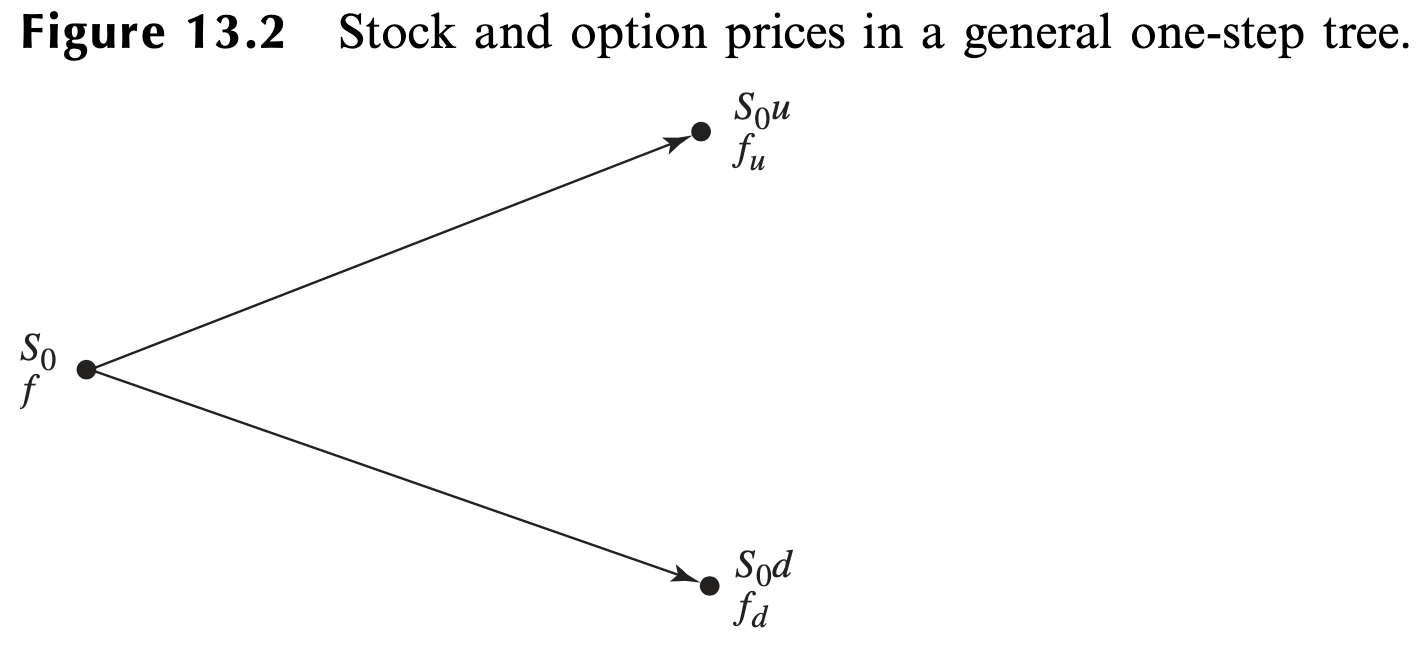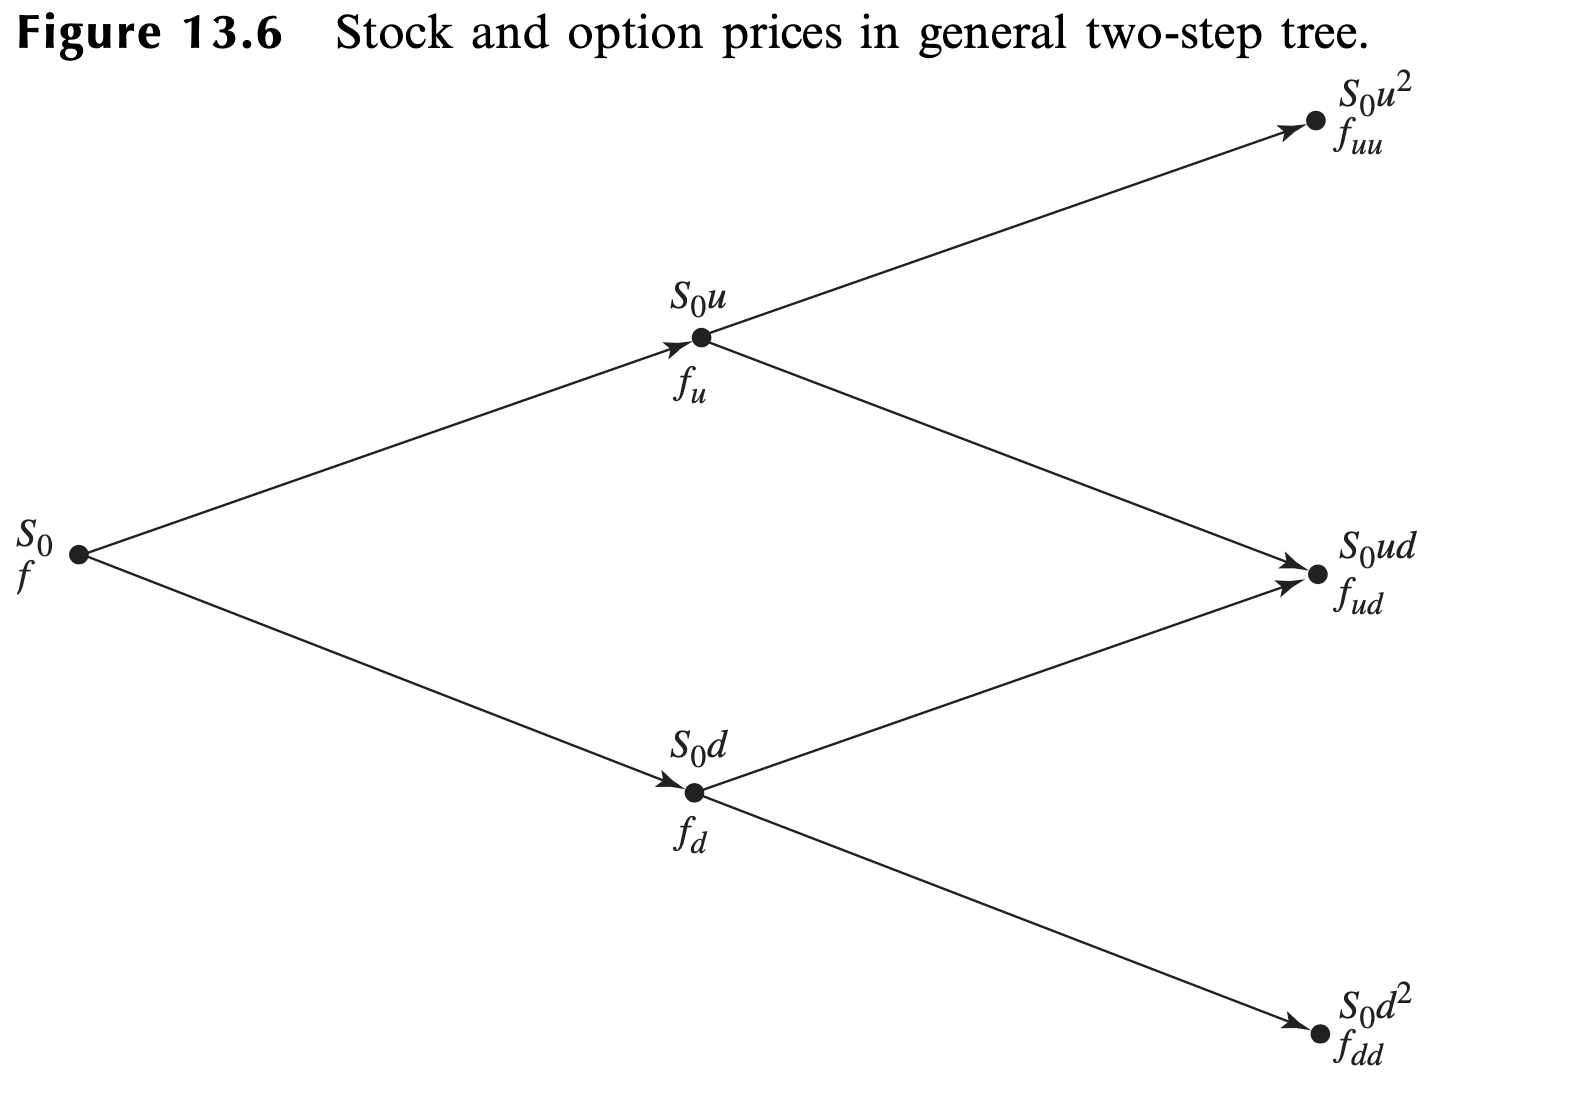

- One step binomial model
  - Assumption: no arbitrage opportunity
  - no certainty about the value of portfolio at maturity
  - Notions:
    - $f$: current price of stock
    - $S_0$: stock price
    - $S_0u$: move up to a higher price, which $u>1$
      - percentage up movement:$u-1$
      - payoff: $f_u$
    - $S_0d$: move down to a lower price, which $d< 1$
      - percentage down movement:$1-d$
      - payoff: $f_d$
  - expected future payoff:  $pf_u+(1-p)f_d$ in risk-neutral world with risk-free rate discounted.
    - rewrite: $E(S_T)=pS_0(u-d)+S_0d$
- Two steps binomial model:
  - Expected future payoff: $f=e^{-2rΔt}[p^2f_{uu}+2p(1-p)f_{ud}+(1-p)^2f_{dd}]$
    - where $p=\frac{e^{rΔt}-d}{u-d}$

In [40]:
#define a class of stock options
import math
class StockOption(object):
        def __init__(self, S0, K, r=0.05, T=1, N=2, pu=0, pd=0, div=0, sigma=0, is_put=False, is_am=False):
            """
            Initialize the stock option base class.
            Default settings:European call.
            
            S0: initial stock price
            K: strike price
            r: risk-free interest rate
            T: time to maturity
            N: number of time steps
            pu: probability at up state
            pd: probability at down state
            div: Dividend yield
            is_put: True for a put option,
                    False for a call option
            is_am: True for an American option,
                   False for a European option
            """
            #initialization
            self.S0 = S0
            self.K = K
            self.r = r
            self.T = T
            self.N = max(1, N)
            self.STs = [] # Declare the stock prices tree
            self.pu, self.pd = pu, pd
            self.div = div
            self.sigma = sigma
            self.is_call = not is_put
            self.is_european = not is_am

        @property
        def dt(self):
            #Single time step, in years 
            return self.T/float(self.N)
            
        @property
        def df(self):
            #The discount factor
            return math.exp(-(self.r-self.div)*self.dt)  

In [42]:
#write a class for European options pricing
from decimal import Decimal

class BinomialEuropeanOption(StockOption):
        def setup_parameters(self):
            # Required calculations for the model
            self.M = self.N+1  # Number of terminal nodes of tree
            self.u = 1+self.pu  # Expected value in the up state
            self.d = 1-self.pd  # Expected value in the down state
            self.qu = (math.exp((self.r-self.div)*self.dt)-self.d)/(self.u-self.d)
            self.qd = 1-self.qu

        def init_stock_price_tree(self):
            # Initialize terminal price nodes to zeros
            self.STs = np.zeros(self.M)

            # Calculate expected stock prices
            for i in range(self.M):
                self.STs[i] = self.S0 * (self.u**(self.N-i)) * (self.d**i)

        def init_payoffs_tree(self):
          
          #Returns the payoffs when the option expires at terminal nodes
          if self.is_call:
              return np.maximum(0, self.STs-self.K)
          else:
              return np.maximum(0, self.K-self.STs)

        def traverse_tree(self, payoffs):
            #Starting from the time the option expires, traverse backwards and calculate discounted payoffs at each node
            for i in range(self.N):
                payoffs = (payoffs[:-1]*self.qu + 
                           payoffs[1:]*self.qd)*self.df

            return payoffs

        def begin_tree_traversal(self):
            payoffs = self.init_payoffs_tree()
            return self.traverse_tree(payoffs)

        def price(self):
            #Entry point of the pricing implementation
            self.setup_parameters()
            self.init_stock_price_tree()
            payoffs = self.begin_tree_traversal()
            
            # Option value converges to first node
            return payoffs[0]

In [44]:
E_option = BinomialEuropeanOption(50, 52, r=0.05, T=2, N=2, pu=0.2, pd=0.2, is_put=True)
print(E_option.price())

4.1926542806038585


### Greeks Calculation
- Overall Defintion: 
  - measures different dimension to the risk in option position.
  - To manage Greeks so that all risks are acceptable.
- $delta$:
  - $Δ=\frac{δc}{δS}$
  - the rate of change of the option price with the underlying asset price.
  - curve slope: option price to underlying asset price
  - delta neutral: a position that $\Delta=0$
    - provide protection against relatively *small* stock price moves between rebalancing.
  - European stock options: no dividend paying
    - $\Delta(call)=N(d_1)$
    - $\Delta(put)=N(d_1)-1$
  - For a portfolio: $Δ=\frac{δ𝜫}{δS}$, where 𝜫 is the value of portfolio
    - $Δ=\sum_{i=1}^nw_iΔ_i$, sum of individual options
      - $w_i$: quantity of an option
- $theta \space 𝚯$
  - Definition: the rate of change of the value of the portfolio with respect to *the passage of time* with all remaining the same.
    - The *time decay* of portfolio
  - European call option,no dividend paying: $𝚯(call)=-\frac{S_0N'(d_1)\sigma}{2\sqrt[2]T}-rKe^{-rT}N(d_2)$
    - $N'(d_1)$: pdf of standard normal distribution
    - $r$: risk-free rate
  - European put option: $𝚯(put)=-\frac{S_0N'(d_1)\sigma}{2\sqrt[2]T}+rKe^{-rT}N(d_2)$
  - Always *negative* for an option. By time passing, options tend to be less valuable.
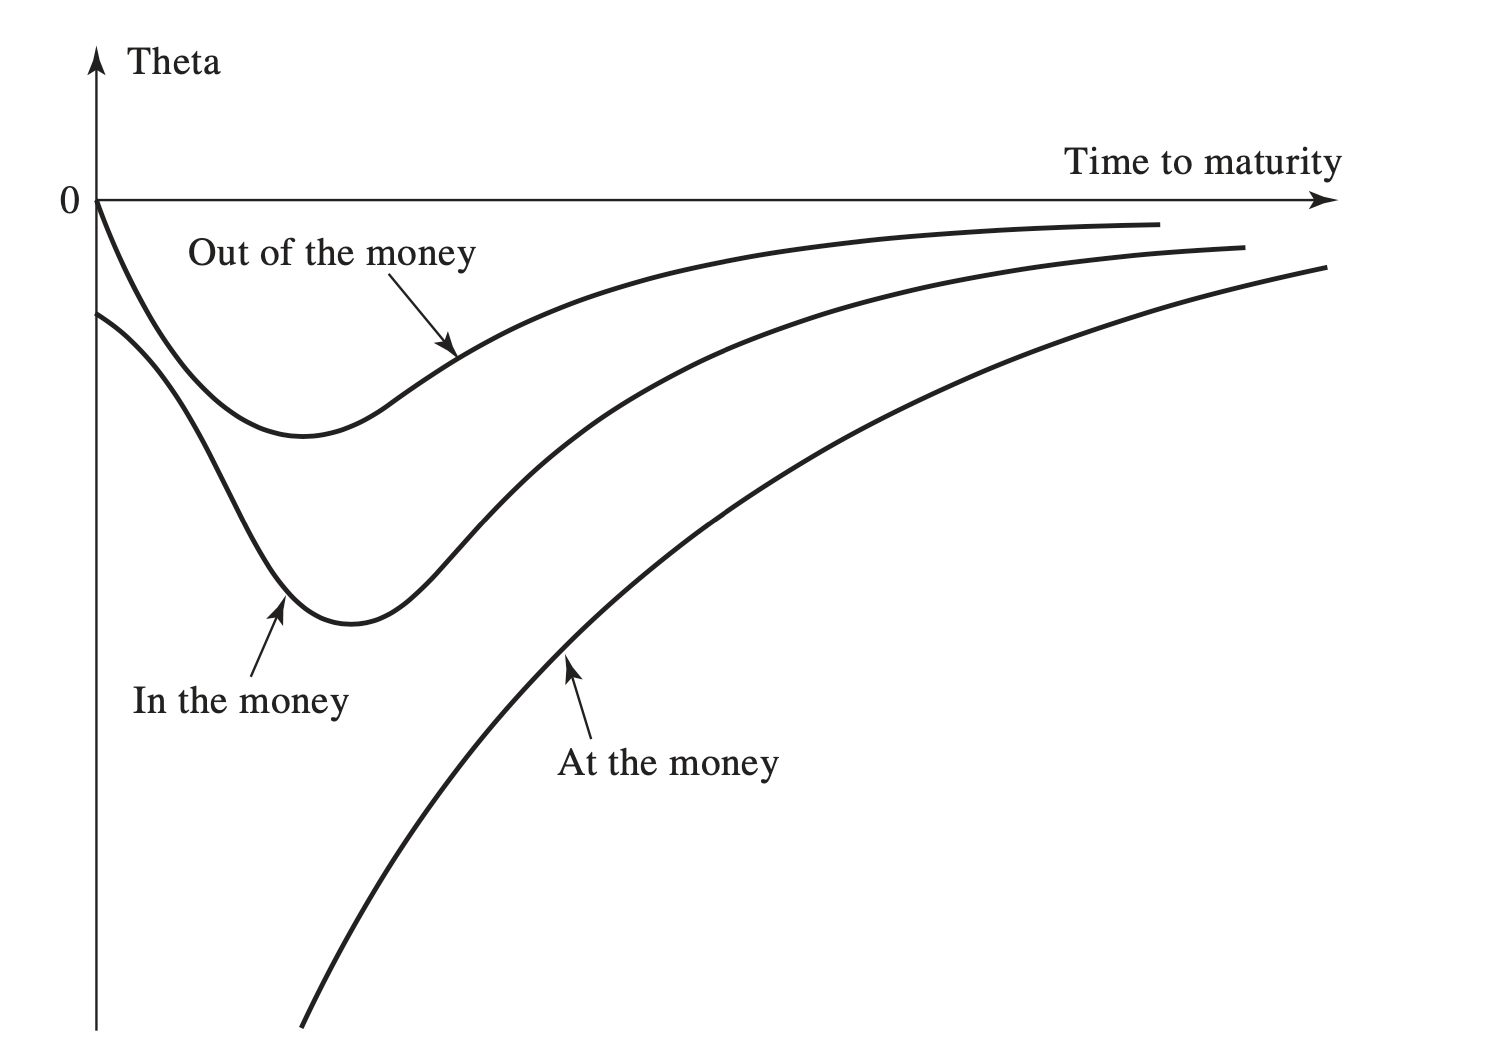

- $Gamma Γ$
  - Definition: the rate of change of portfolio's **delta** with repect to the price of underlying asset.
  - Gamma neutral:
    - for portfolio only exists a short period of time.
    - the position to make Gamma neutral: $-\Gamma/\Gamma_T$
      - $\Gamma$: the gamma of delta-neutral portfolio
      - $\Gamma_T$: the gamma of a traded option added to the portfolio
    - provide the protection against relatively *large movements* in the stock price between hedge rebalancing.
  - $\Gamma=\frac{\delta^2 𝜫}{δS^2}$
    - if delta is small, Gamma changes slowly.
  - Calculation:
    - European call or put option:$Γ=\frac{N'(d_1)}{S_0\sigma\sqrt[2]T}$
  - always>0
- Relationship of above three:
  - $𝚯+rS𝝙+\frac{1}{2}\sigma^2S^2Γ=r𝜫$
  - When it comes to delta neutral portfolio, $𝚯+\frac{1}{2}\sigma^2S^2Γ=r𝜫$
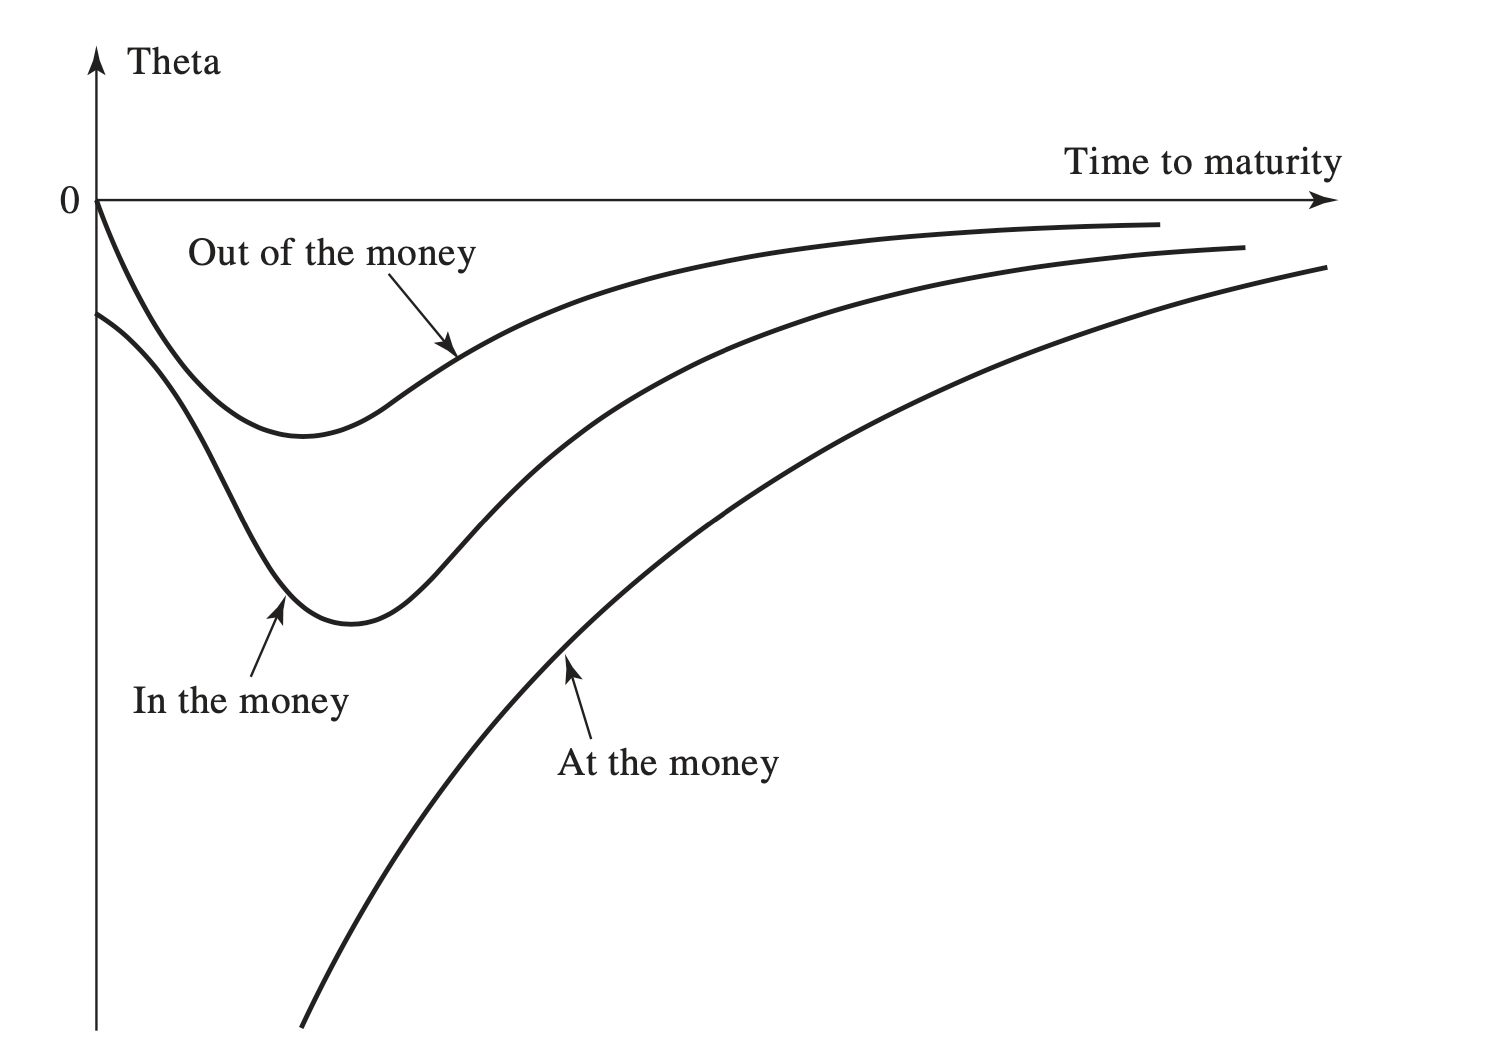

- $Vega \space 𝛎(Zeta \space or \space Kappa)$
  - Definition: the rate of the value of portfolio with respect to the volatility of the underlying asset.
  - Formula: $𝛎=\frac{δ𝜫}{δσ}$
  - if vega is highly positive or negative, the portfolio value is very sensitive to volatility.
  - European call or put option with non-dividend paying: $𝛎=S_0\sqrt[2]T N'(d_1)$
  - Vega neutral position: $-𝛎/𝛎_T$
    - $𝛎_T$: the vega of a traded option
    - Notice: when a portfolio reaches up to gamma neutral not indicates in general it is vega neutral.
      - if we want to get Gamma and Vega neutral simultaneously, at least 2 traded derivatives underlying assets are needed, with quantity $w_i$.

- $rho \space ρ$
  - Definition: value of portfolio with respect to the given interest rate
  - function: $\frac{δ𝜫}{δr}$
  - Calulcation: European option without dividend
    - $\rho_c=KTe^{-rT}N(d_2)$
    - $\rho_p=-KTe^{-rT}N(-d_2)$

In [66]:
#parameter specification
S=100
K=100
r=0.05
T=30/365
sigma=0.2

In [67]:
d1 = (np.log(S/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)

In [70]:
delta = norm.cdf(d1,0,1)
gamma = norm.pdf(d1,0,1)/(S*sigma*np.sqrt(T))
theta=(-S*norm.pdf(d1,0,1)*sigma)/(2*np.sqrt(T)) -r*K*np.exp(-r*T)*norm.cdf(d2,0,1)
vega = S*norm.pdf(d1,0,1)*np.sqrt(T)
vomma = vega*d1*d2/sigma
rho=K*T*np.exp(-r*T)*norm.cdf(d2,0,1)

In [71]:
greeks = [delta, gamma, theta, vega, vomma, rho]
greeks_labels = ['Delta', 'Gamma', 'Theta', 'Vega', 'Vomma','rho']

<ipython-input-72-b004ee0a5a1e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


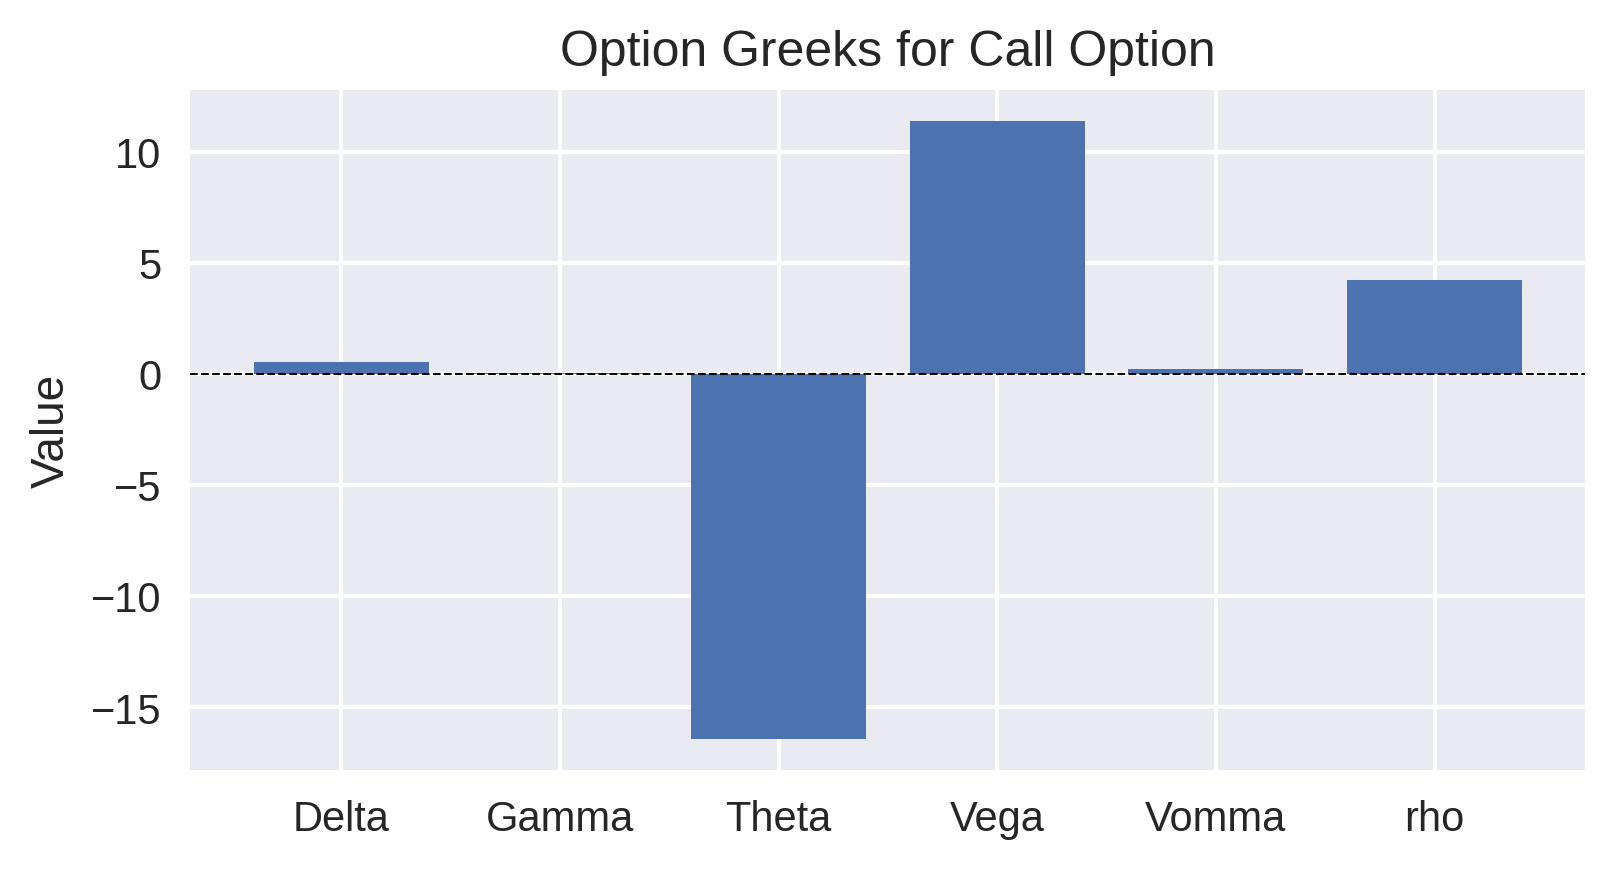

In [72]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize=(6, 3)) 
ax.bar(greeks_labels, greeks) 
ax.set_title('Option Greeks for Call Option') 
ax.set_ylabel('Value')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5) 
plt.show()

## Estimating VaR Using Monte Carlo
- Three Approaches to Calculate VaR
  - Variance-Covariance
    - $VaR=P-P(N^{-1}(\alpha, u, \sigma)+1)$
  - Historical simulation approach
  - Monte Carlo simulations

### VaR
- Defintion: under the worst expected loss at a given level of confidence(X%) over a certain time horizon(N) under normal market conditions.
  - Normally, we just present loss in abs value format.
  - "I am X percent certain there will not be a loss of more than V dollars in the next N days."
    - Time conversion: $N-day \space VaR=1-day \space VaR * \sqrt[2]{N}$
-  VaR: the loss corresponding to the (100-X)th percentile of the distribution of the gain in the value of the portfolio over the next N days. 
- In this case, we select Spotify(SPOT), Snowflake(SNOW), Dropbox(DBX), DoorDash(DASH) to calculate a 1-day Value-at-Risk.


In [27]:
!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 69.4 MB/s eta 0:00:00


In [28]:
stock = ['SPOT', 'SNOW','DBX','DASH']
Shares = [25, 25, 25, 25]
SD = '2022-01-01'
ED = '2022-12-31'
T = 1
N_SIMS = 10**5

- Get VaR from Prices: use # of share and stock price
- Get VaR from Returns: use percentage weights of each stock and expected return

In [29]:
#download data
price=yf.download(stock, start=SD, end=ED, progress=False)

<ipython-input-30-3ffe46204908>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Axes: title={'center': 'SPOT & SNOW & DBX & DASH returns: 2022-01-01 - 2022-12-31'}, xlabel='Date'>

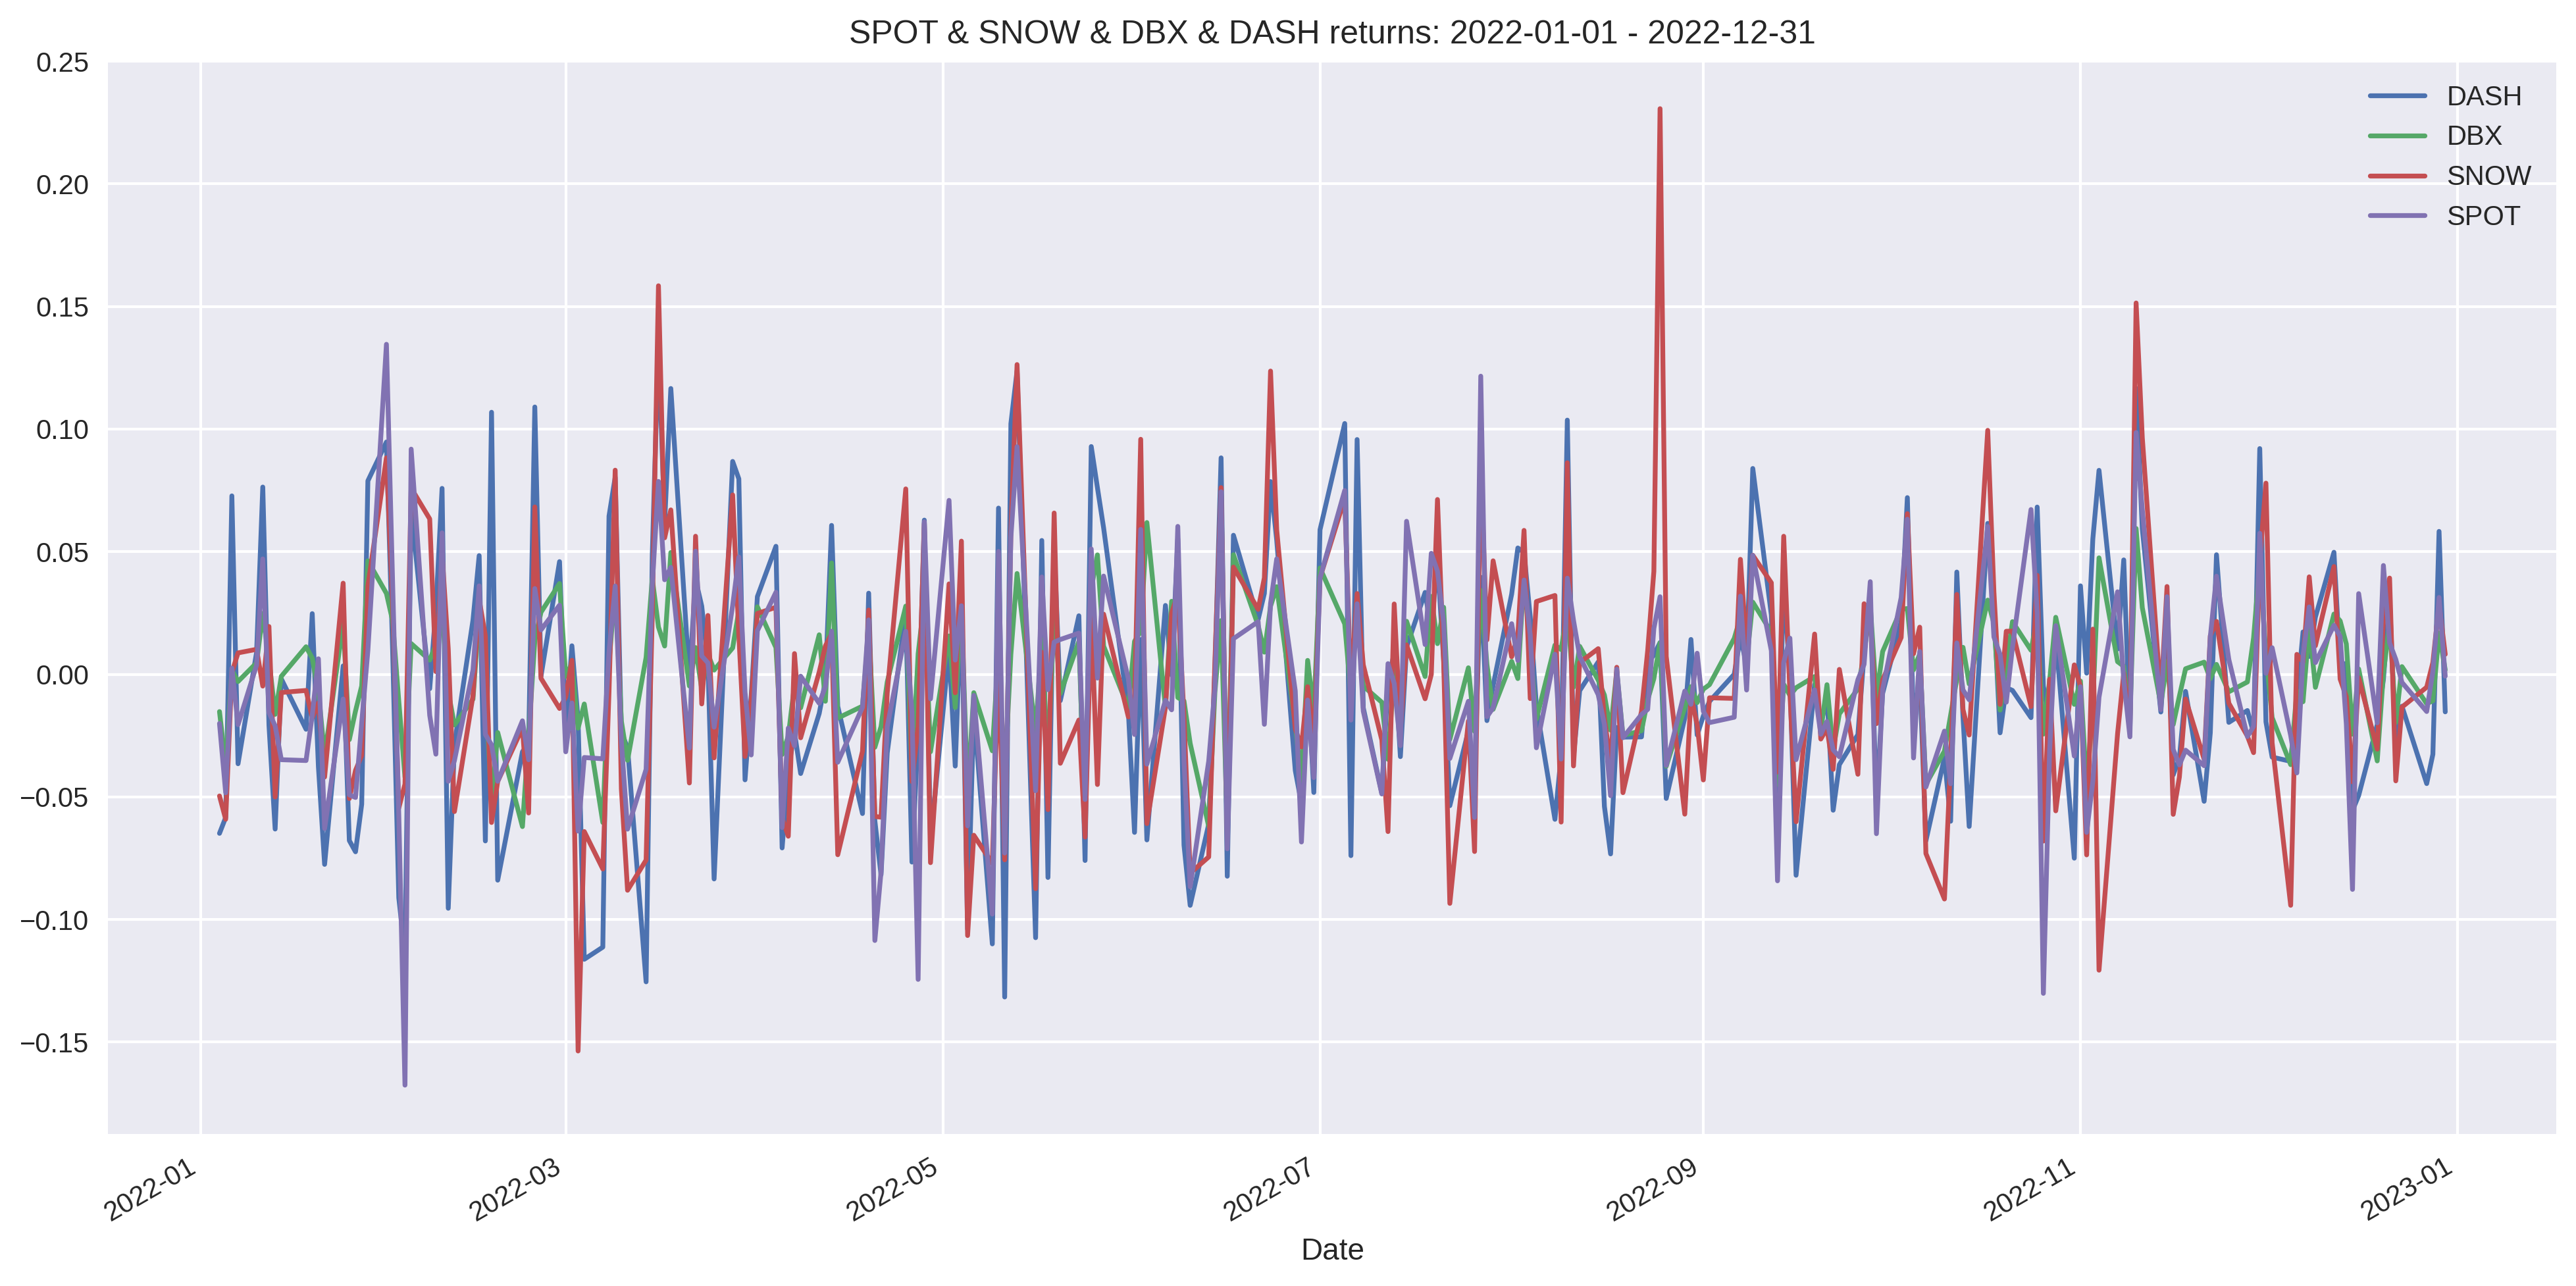

In [30]:
#get the simple daily return, deal with the missing value
adj_close =price['Adj Close']
returns = adj_close.pct_change().dropna()
# plot the returns
plot_title = f'{" & ".join(stock)} returns: {SD} - {ED}'
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
returns.plot(title=plot_title,figsize=(16,8))

In [31]:
#get the covariance matirx
covariance_matrix = returns.cov()
covariance_matrix

,DASH,DBX,SNOW,SPOT
DASH,0.002871,0.000876,0.001831,0.001643
DBX,0.000876,0.000567,0.000779,0.000670
SNOW,0.001831,0.000779,0.002535,0.001475
SPOT,0.001643,0.000670,0.001475,0.001730


In [32]:
#get the Cholesky decomposition 
Cholesky_decomposition = np.linalg.cholesky(covariance_matrix)

- Another decomposition way using SVD by `np.linalg.svd`

### Cholesky Decomopsition
- Formula: $A=LL^*$
  - $L$: low triangular matrix with positive diagonal values, and $L^*$ is a conjugate transpose of $L$ 
- Variant: $A=LDL*$
  - $L$: lower unit triangular matrix
- Application in Financial assets: $\sigma_p^2=α^T C α$
  - $C$: covariance matrix


In [33]:
#Standard Normal distribution draw random variables
rv = np.random.normal(size=(N_SIMS, len(stock)))
#Compute conjugate transpose,Reconstruct coefficient matrix, adding the correlation
correlated_rv = np.transpose(np.matmul(Cholesky_decomposition, np.transpose(rv)))

In [34]:
#assign values to parameters
r = np.mean(returns, axis=0).values #historical average
sigma = np.std(returns, axis=0).values
S0 = adj_close.values[-1, :] #lastest known stock price
P0 = np.sum(Shares*S0) 

In [35]:
#calculate final price with close formula
S_T = S0*np.exp((r -0.5* sigma**2)*T + sigma*np.sqrt(T)* correlated_rv)

In [36]:
#compute the 1-day ahead final portfolio value and net profits
P_T = np.sum(Shares*S_T, axis=1)
Profit = P_T - P0

In [37]:
#Calculate VaR with different CI
Profit_sorted = np.sort(Profit)  #in ascending order
percentiles = [0.01, 0.1, 1.0]
var = np.percentile(Profit_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 80.27$
1-day VaR with 99.9% confidence: 71.49$
1-day VaR with 99.0% confidence: 60.43$


<ipython-input-38-0c3951939965>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(Profit, kde=False)


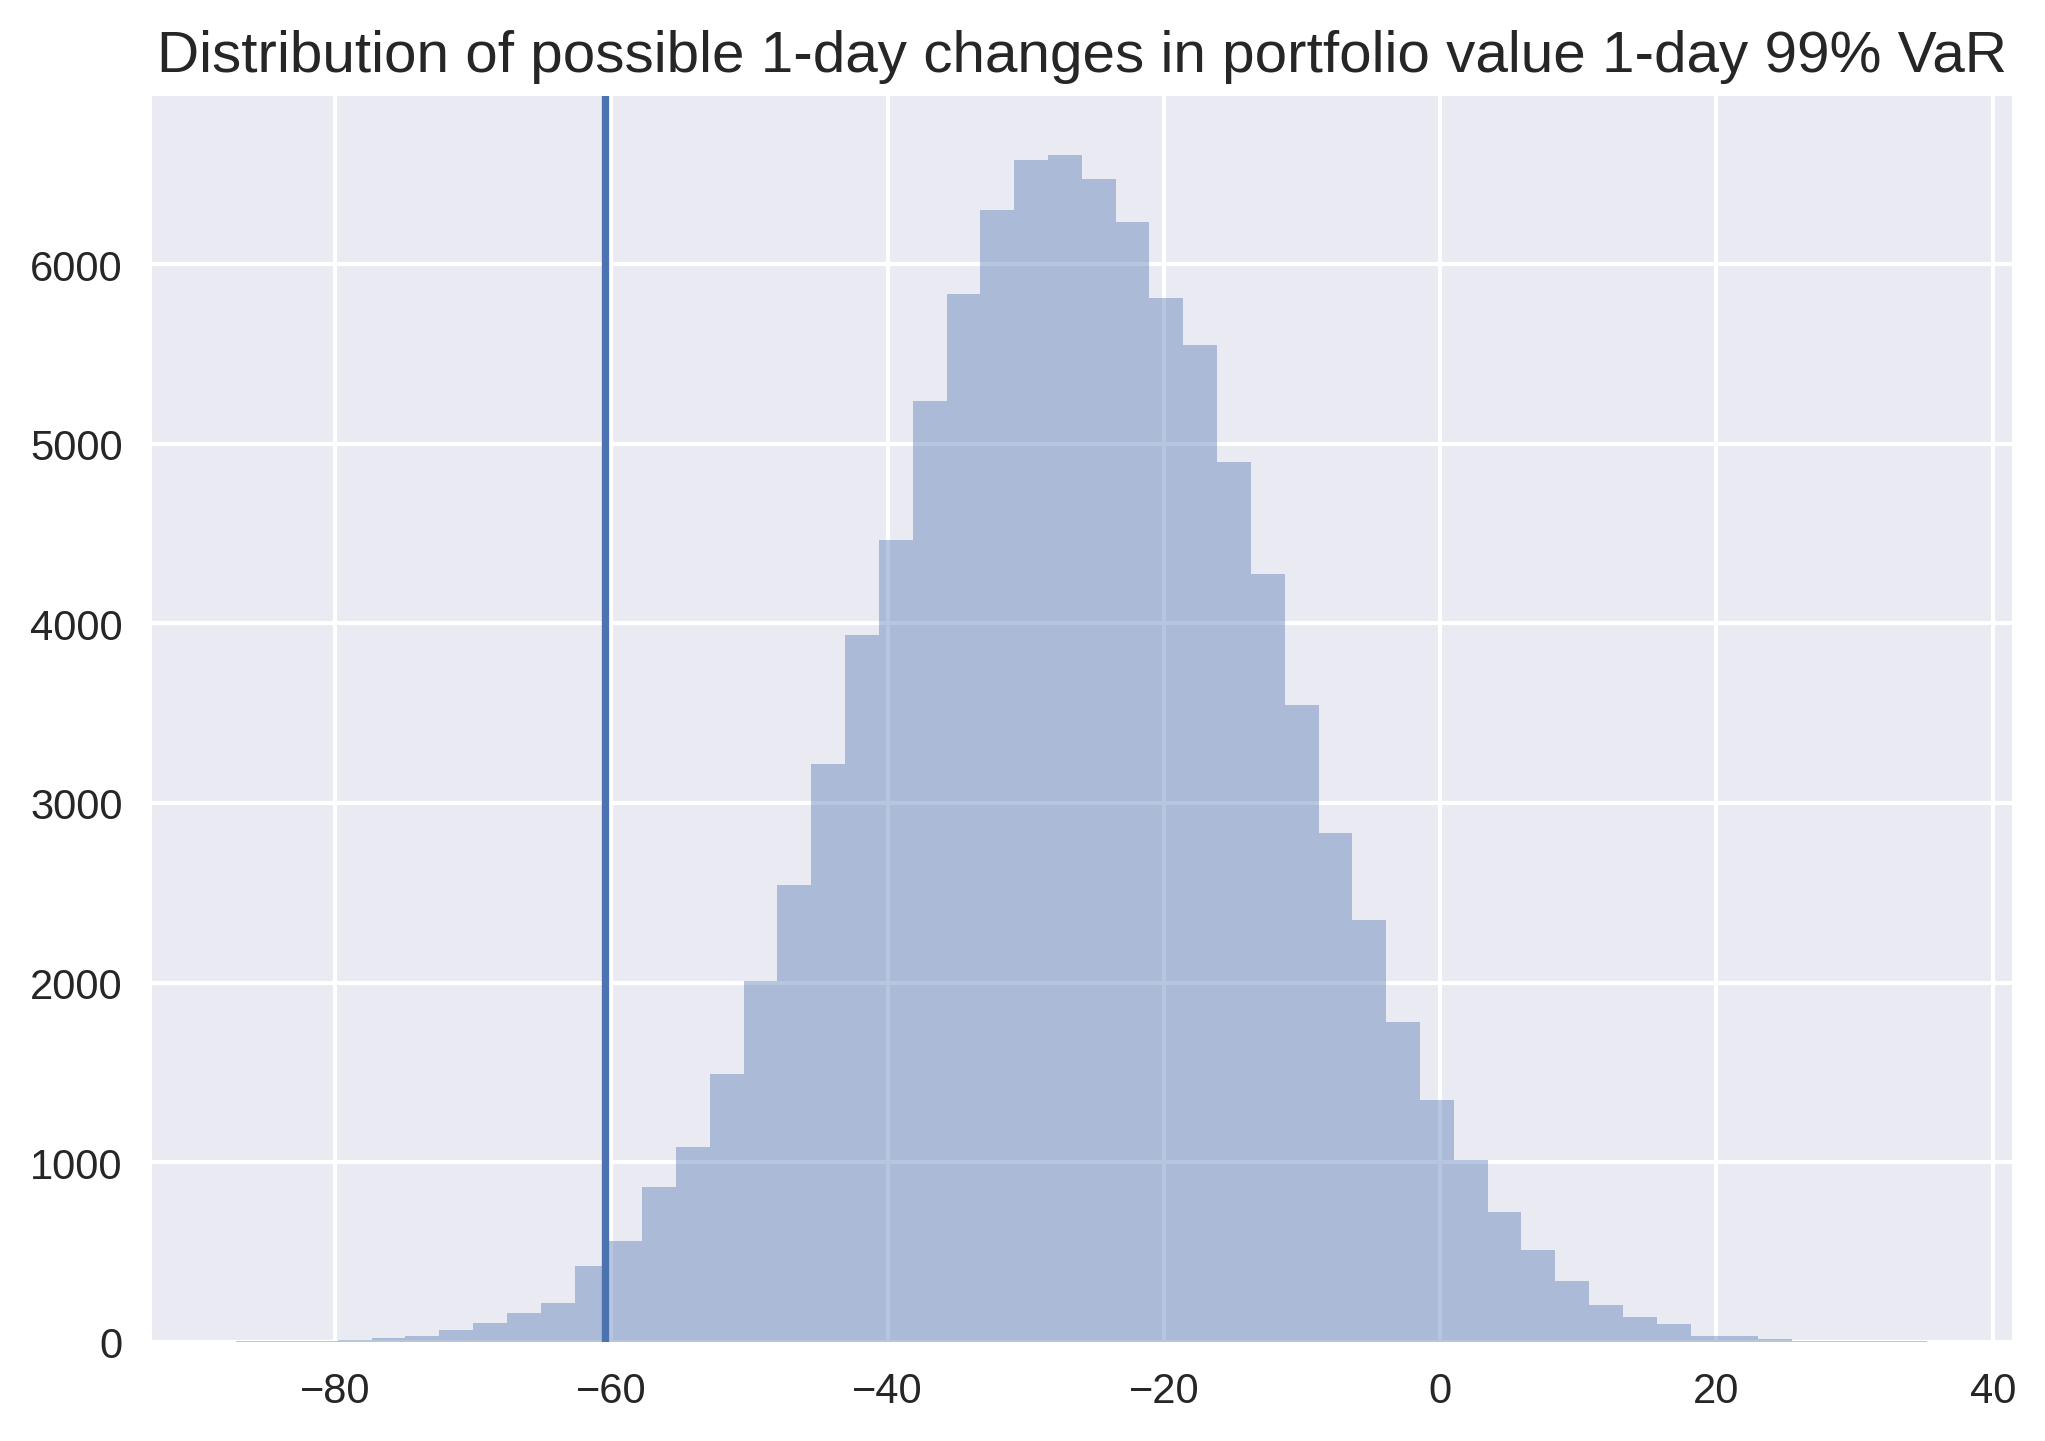

In [38]:
ax = sns.distplot(Profit, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 1-day 99% VaR''', fontsize=14)
ax.axvline(var[2], 0, 10000);

- The displot presents one-day ahead porfolio return distritbution with VaR in vertical line.
- Bank:
  - frequently calculate **1-day** or **10-day** VaR to decide the capital requirement.
  - $k* VaR$, k is bank-to-bank basis by regulators and >= 3.0
- Drawback: 
  - not contain information about the size of the potential loss when it exceeds the threshold given by VaR.
  - Not capturing enough tail risk.
  - Not considering the so-called Black Swan events and slow to adapt to new market conditions.

### Expected Shortfall:(Conditional VaR)
- It simply states what the expected loss is in the worst X% of scenarios.
- the potential loss
- Procedure: 
  - filter out all losses > VaR 
  - calculate expected value by taking average.

In [39]:
var5 = np.percentile(Profit_sorted, 5)
expected_shortfall = Profit_sorted[Profit_sorted<=var5].mean()
print(var5, expected_shortfall)

-50.48958765613979 -56.62005216577954


- If the loss exceeds the 95% VaR, we can expect to lose $56.68 by holding our portfolio for 1 day.

- 1-day VaR is $50.65